# Load all I need, please?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback, EarlyStopping
from time import time

Using TensorFlow backend.


# Load the data

In [2]:
# Load npz file containing image arrays
x_npz = np.load("x_224.npz")
x = x_npz['arr_0']
# Load binary encoded labels for 0:pp -> jj, 1:pp -> t tbar
y_npz = np.load("y_224.npz")
y = y_npz['arr_0']

In [3]:
#0: not found, 1: found
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 3499, 1: 3499}


In [4]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

# Second split the 20% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)


In [5]:
# I'm using the categorical cross entropy as loss function,
#so we need to convert our labels streming into a category list
nb_categories = 2

#use this to compare if label binarize is better than to_categorical
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,nb_categories)
y_test = np_utils.to_categorical(y_test,nb_categories)
y_valtest = np_utils.to_categorical(y_valtest,nb_categories)
y_val = np_utils.to_categorical(y_val,nb_categories)


In [6]:
print(np.array(X_train).shape)
print(np.array(X_val).shape)
print(np.array(X_test).shape)

(5598, 224, 224, 3)
(700, 224, 224, 3)
(700, 224, 224, 3)


In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras import backend as K

In [8]:
img_width, img_height = X_train.shape[1], X_train.shape[2]
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
epochs = 10
batch_size = 16

# Building our model

In [9]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3),name="entrada"))
model.add(layers.BatchNormalization(name="batch_norm_0"))
model.add(layers.Activation("relu",name="activation_0"))

model.add(layers.MaxPooling2D((2, 2),name="max_pooling_0"))

model.add(layers.Conv2D(64, (3, 3),name="conv2D_1"))
model.add(layers.BatchNormalization(name="batch_norm_1"))
model.add(layers.Activation("relu",name="activation_1"))

model.add(layers.MaxPooling2D((2, 2),name="max_pooling_N1"))

######################################################
model.add(layers.Conv2D(64, (3, 3),name="conv2D_N1"))
model.add(layers.BatchNormalization(name="batch_norm_N1"))
model.add(layers.Activation("relu",name="activation_N1"))
###########################################################
model.add(layers.MaxPooling2D((2, 2),name="max_pooling_N2"))
######################################################
model.add(layers.Conv2D(64, (3, 3),name="conv2D_N2"))
model.add(layers.BatchNormalization(name="batch_norm_N2"))
model.add(layers.Activation("relu",name="activation_N2"))
###########################################################

model.add(layers.MaxPooling2D((2, 2),name="max_pooling_1"))

model.add(layers.Conv2D(128, (3, 3),name="conv2D_2"))
model.add(layers.BatchNormalization(name="batch_norm_2"))
model.add(layers.Activation("relu",name="activation_2"))


model.add(layers.MaxPooling2D((2, 2),name="max_pooling_2"))

model.add(layers.Flatten(name="achata"))
model.add(layers.Dropout(0.2,name="dropout_0"))
model.add(layers.Dense(64,name="dense_0"))
model.add(layers.BatchNormalization(name="batch_norm_3"))
model.add(layers.Activation("relu",name="activation_3"))

model.add(layers.Dense(2,name="classificator"))
model.add(layers.BatchNormalization(name="batch_norm_4"))
model.add(layers.Activation("sigmoid",name="activation_4"))
#sparse_categorical_crossentropy
#binary_crossentropy
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
    metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
entrada (Conv2D)             (None, 222, 222, 32)      896       
_________________________________________________________________
batch_norm_0 (BatchNormaliza (None, 222, 222, 32)      128       
_________________________________________________________________
activation_0 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling_0 (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 109, 109, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 64)      0         
__________

# I'm going to use data augmentation.

In [10]:
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True, rotation_range=30)
valtest_datagen = ImageDataGenerator(rescale=1. / 255)

In [11]:
train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size,shuffle=False)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size=batch_size, shuffle=False)
test_generator = valtest_datagen.flow(np.array(X_test), y_test, batch_size=batch_size,shuffle=False)


In [16]:
tensorboard = TensorBoard(log_dir="logs_layers_{}/{}".format(time(),len(model.layers)),histogram_freq=0,write_images=True, write_grads=True)
checkpointer = ModelCheckpoint(filepath='./weights_{}_layers_{}.hdf5'.format(time(),len(model.layers)), verbose=1, save_best_only=True)
earlierstop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [18]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensorboard,checkpointer,earlierstop],
)

Epoch 1/10
349/349 [==============================] - 1057s 3s/step - loss: 0.3220 - acc: 0.9527 - val_loss: 0.9137 - val_acc: 0.4985

Epoch 00001: val_loss improved from inf to 0.91375, saving model to ./weights_1538715140.41_layers_28.hdf5
Epoch 2/10
349/349 [==============================] - 1192s 3s/step - loss: 0.2338 - acc: 0.9622 - val_loss: 0.8744 - val_acc: 0.5029

Epoch 00002: val_loss improved from 0.91375 to 0.87440, saving model to ./weights_1538715140.41_layers_28.hdf5
Epoch 3/10
349/349 [==============================] - 1176s 3s/step - loss: 0.1801 - acc: 0.9672 - val_loss: 0.5613 - val_acc: 0.6520

Epoch 00003: val_loss improved from 0.87440 to 0.56133, saving model to ./weights_1538715140.41_layers_28.hdf5
Epoch 4/10
349/349 [==============================] - 1104s 3s/step - loss: 0.1467 - acc: 0.9722 - val_loss: 1.4247 - val_acc: 0.4971

Epoch 00004: val_loss did not improve
Epoch 5/10
349/349 [==============================] - 1161s 3s/step - loss: 0.1236 - acc: 0.9

In [12]:
model.load_weights('weights_1538715140.41_layers_28.hdf5')

In [13]:
import sklearn
import itertools
from sklearn.metrics import confusion_matrix
dict_characters = { 1: '$pp \\rightarrow t \\bar{t}$', 0: '$pp \\rightarrow j j$'}
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',fontsize=20,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=17)
    plt.yticks(tick_marks, classes,fontsize=17)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black", fontsize=20)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

In [14]:
a=X_train
b=y_train
c=X_valtest
d=y_valtest
Y_pred = model.predict_generator(validation_generator,nb_validation_samples // batch_size+1)
Y_pred_classes = np.argmax(Y_pred,axis=1)


In [22]:
model.evaluate_generator(validation_generator,nb_validation_samples // batch_size)

[0.56026686970577688, 0.65116279069767447]

In [15]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(validation_generator.y,axis=1), Y_pred_classes, target_names=list(dict_characters.values())))

                            precision    recall  f1-score   support

      $pp \rightarrow j j$       0.59      1.00      0.74       350
$pp \rightarrow t \bar{t}$       1.00      0.31      0.47       350

               avg / total       0.80      0.65      0.61       700



In [16]:
cnf_matrix = confusion_matrix(np.argmax(validation_generator.y, axis=1), Y_pred_classes)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[350   0]
 [243 107]]


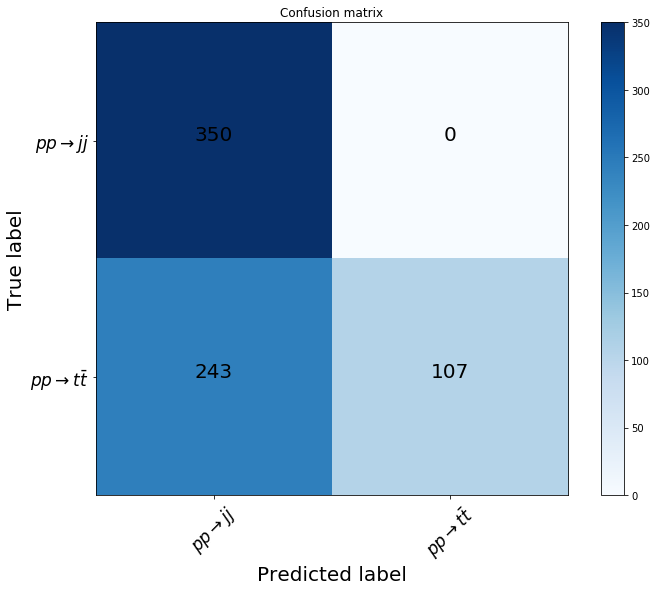

In [27]:
# Plot non-normalized confusion matrix
plt.figure(figsize=[10,8])
plot_confusion_matrix(cnf_matrix, classes=list(dict_characters.values()),
                      title='Confusion matrix')
#plt.savefig("/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/confusion_matrix_Infiltration.pdf")
plt.show()

Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.69  0.31]]


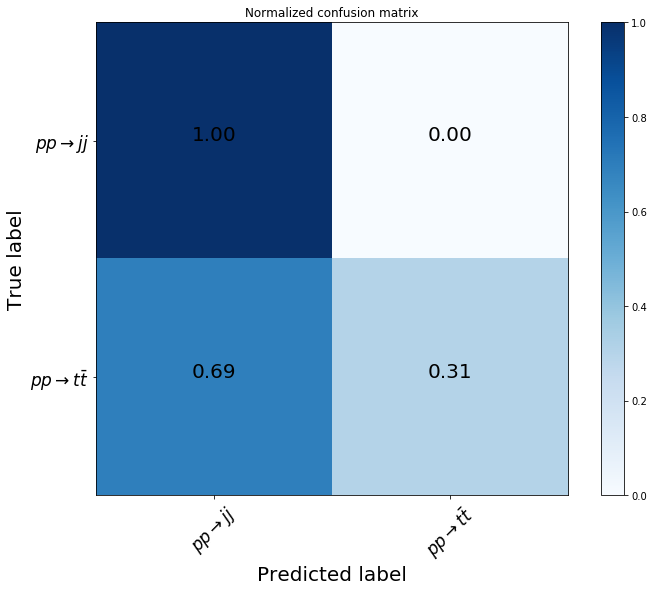

In [17]:
plt.figure(figsize=[10,8])
plot_confusion_matrix(cnf_matrix, classes=dict_characters.values(), normalize=True,
                      title='Normalized confusion matrix')

plt.savefig("norm_CM.pdf")
plt.show()

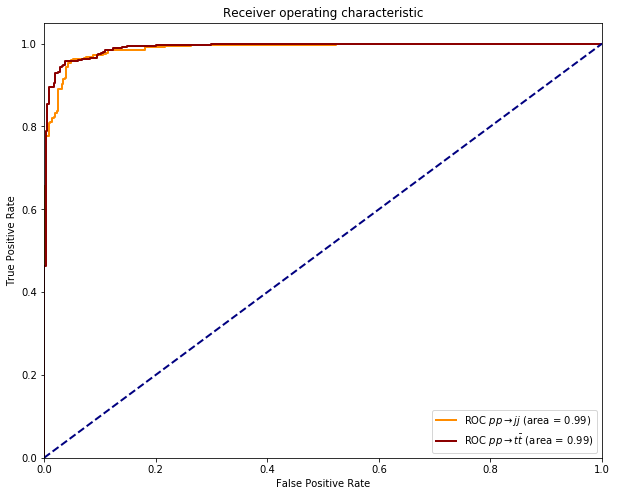

In [20]:
from sklearn.metrics import roc_curve, auc

fpr0, tpr0, thresholds0 = roc_curve(validation_generator.y[:,0], Y_pred[:,0])
fpr1, tpr1, thresholds1 = roc_curve(validation_generator.y[:,1], Y_pred[:,1])
roc_auc0 = auc(fpr0, tpr0)
roc_auc1 = auc(fpr1, tpr1)

plt.figure(figsize=[10,8])
lw = 2
plt.plot(fpr0, tpr0, color='darkorange',
         lw=lw, label='ROC $pp \\rightarrow j j$ (area = %0.2f)'%(roc_auc0))
plt.plot(fpr1, tpr1, color='darkred',
         lw=lw, label='ROC $pp \\rightarrow t \\bar{t}$ (area = %0.2f)'%(roc_auc1))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_test.pdf')
plt.show()

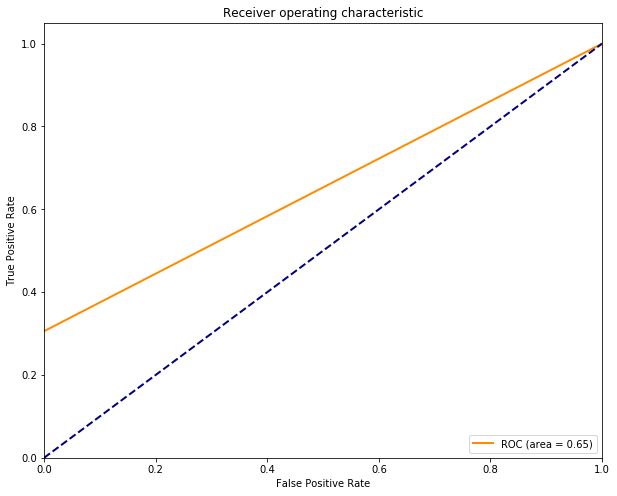

In [31]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(np.argmax(validation_generator.y,axis=1), Y_pred_classes)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[10,8])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
#plt.savefig('/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/ROC_unweighted_avg.pdf')
plt.legend(loc="lower right")
plt.show()

In [32]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

In [33]:
precision0, recall0, thresholds0 = precision_recall_curve(validation_generator.y[:,0], Y_pred[:,0])
precision1, recall1, thresholds1 = precision_recall_curve(validation_generator.y[:,1], Y_pred[:,1])

In [35]:
from sklearn.metrics import average_precision_score
average_precision0 = average_precision_score(validation_generator.y[:,0], Y_pred[:,0])
average_precision1 = average_precision_score(validation_generator.y[:,1], Y_pred[:,1])

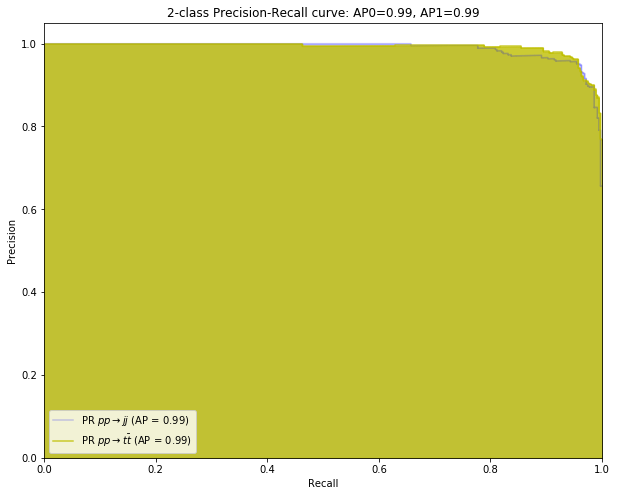

In [36]:
plt.figure(figsize=[10,8])
plt.step(recall0, precision0, color='b', alpha=0.2,
         where='post',label='PR $pp \\rightarrow j j$ (AP = %0.2f)'%(average_precision0))
plt.fill_between(recall0, precision0, step='post', alpha=0.2,
                 color='b')
plt.step(recall1, precision1, color='y', alpha=0.8,
         where='post',label='PR $pp \\rightarrow t \\bar{t}$ (AP = %0.2f)'%(average_precision1))
plt.fill_between(recall1, precision1, step='post', alpha=0.8,
                 color='y')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP0={0:0.2f}, AP1={1:0.2f}'.format(
          average_precision0,average_precision1))
plt.legend(loc="best")
#plt.savefig('/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/PR_unweighted.pdf')
plt.show()


In [37]:
precision, recall, thresholds = precision_recall_curve(np.argmax(validation_generator.y, axis=1), Y_pred_classes)
average_precision = average_precision_score(np.argmax(validation_generator.y, axis=1), Y_pred_classes)

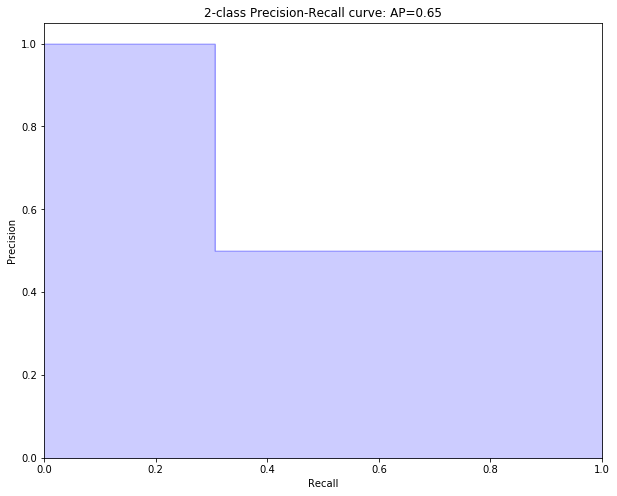

In [38]:
plt.figure(figsize=[10,8])
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
#plt.savefig('/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/PR_unweighted_avg.pdf')
plt.show()